# Recommender systems

## Load the dataset

We have collected food ratings from different students. The numbers have the following meaning:

Rating explanation (range from 0 to 10):	

|Rating|Description|
|-|-|
| 0	|I have never tried this food|
| 1	|I hate this food, would never eat that|
| 5	|I don't mind eating this but not a fan either / Never tried|
| 10|	I absolutely LOVE this food|

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [34]:
food = pd.read_csv('data/food_ratings.csv', index_col='student')
food.drop(['age','favorite_color'], axis=1, inplace=True)
food

,broccoli,brussels_sprouts,hamburger,oysters (raw),onion (raw),peas,olives,blue_cheese,whisky
student,,,,,,,,,
Akbar,7,0,5,1,3,4,8,8,7
Andreas,7,7,7,0,7,3,3,5,7
Dónal,8,6,8,5,1,5,8,10,10
Hana,0,8,8,8,0,7,9,8,7
Konstantinos,7,7,1,10,10,8,10,2,7
Kristina,9,8,0,0,7,7,9,2,7
Sabrina,6,0,10,1,8,0,10,1,5
Sandrine,10,2,8,1,5,8,10,10,0
Sevgi,6,2,9,0,5,7,10,1,0


## Popularity base

In [35]:
# by ratings
(
food
    .reset_index()
    .melt(id_vars=['student'], value_vars=food.columns)
    .query('value != 0')
    .groupby('variable')
    .agg(mean_rating = ('value', 'mean'))
    # .reset_index()
    # .sort_values('mean_rating', ascending=False)
    .head(10)
    )

,mean_rating
variable,
onion (raw),6.000000
blue_cheese,6.000000
broccoli,7.545455
brussels_sprouts,5.181818
hamburger,7.000000
olives,8.538462
oysters (raw),4.111111
peas,6.333333
whisky,7.818182


In [36]:
# by ratings count
(
food
    .reset_index()
    .melt(id_vars=['student'], value_vars=food.columns)
    .query('value != 0')
    .groupby('variable')
    .agg(count_rating = ('value', 'count'))
    # .reset_index()
    # .sort_values('count_rating', ascending=False)
    .head(10)
    )

,count_rating
variable,
onion (raw),11
blue_cheese,13
broccoli,11
brussels_sprouts,11
hamburger,11
olives,13
oysters (raw),9
peas,12
whisky,11


In [37]:
# create a metric based on popularity and rating

def popularity_rating(df,item,num):
    ratings = (
    df
        .reset_index()
        .melt(id_vars=['student'], value_vars=food.columns)
        .query('value != 0')
        .groupby('variable')
        .agg(mean_rating = ('value', 'mean'), count_rating = ('value', 'count'))
    )
    ratings = ratings.assign(rating = ratings['mean_rating'] * ratings['count_rating']).reset_index().sort_values('rating', ascending=False)
    return ratings.head(num)

In [38]:
popularity_rating(food,0,5)

,variable,mean_rating,count_rating,rating
5,olives,8.538462,13,111.0
8,whisky,7.818182,11,86.0
2,broccoli,7.545455,11,83.0
1,blue_cheese,6.000000,13,78.0
4,hamburger,7.000000,11,77.0


## Item-based recommender system

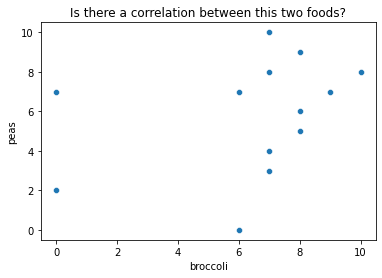

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(data=food, x='broccoli', y='peas')
plt.title('Is there a correlation between this two foods?')
plt.show()

In [40]:
food.corrwith(food['broccoli']).sort_values()

hamburger          -0.304354
oysters (raw)      -0.142466
blue_cheese        -0.094231
whisky              0.007481
olives              0.047733
brussels_sprouts    0.102460
 onion (raw)        0.115584
peas                0.327144
broccoli            1.000000
dtype: float64

### Exercise

Write a function that takes as inputs a food and a number of recommendations (n), and outputs the n most correlated foods

In [41]:
def n_recommendations(food, food_title, n):
    correlations = food.corrwith(food[food_title])
    correlations.sort_values(ascending=False).head(20)
    recommendation = pd.DataFrame(correlations,columns=['Correlation'])
    recommendation.dropna(inplace=True)
    recommendation = recommendation.join(Average_ratings['Total Ratings'])
    recc = recommendation[recommendation['Total Ratings']>100].sort_values('Correlation',ascending=False).reset_index()
    return list(recc.iloc[1:n+1].title)

## User-based recommender system

Steps to build a recommender system:
    
1. I know the foods that all users have eaten and the ones that have not and if they like or not.
2. Based on that info, I can look at how similar one student is to the others. To achieve it, we can use the cosine distance. It will return us a value between 0 and 1; 0 will be closer to our user, and 1 would be far away from our user. To transform them as a similitude metric, we can apply: 
$$cosine\ similitude = 1 - cosine\ distance$$
Then the students closer to each other will have a value closer to 1, and the other will be closer to 0. To know more information about cosine distance, I recommend to watch the following [video](https://www.youtube.com/watch?v=ieMjGVYw9ag).


3. Once we have found the most similar user, we will ponderate the results to see which food has not been seen by our user that is closer to its ratings. 

Let's look at one example: 

### 1st iteration: small example

In [42]:
sample = food.iloc[:4, :3].copy()
sample

,broccoli,brussels_sprouts,hamburger
student,,,
Akbar,7,0,5
Andreas,7,7,7
Dónal,8,6,8
Hana,0,8,8


In this small sample, we have 4 students who has rated 3 different foods. One of them, Shikha, has not rated the food **hamburger**, as its value is 0 (in that case is filled with 0, but in a lot of cases will be a `NaN`.

The goal here will be to try to predict the rating she will give to it by looking at the rating that has been given for the closer student to her.

In [43]:
from sklearn.metrics.pairwise import cosine_distances

In [44]:
sample_distance = pd.DataFrame(cosine_distances(sample), columns=sample.index, index=sample.index)
sample_distance

student,Akbar,Andreas,Dónal,Hana
student,,,,
Akbar,0.000000,0.194613,0.128568,0.589003
Andreas,0.194613,0.000000,0.008163,0.183503
Dónal,0.128568,0.008163,0.000000,0.226979
Hana,0.589003,0.183503,0.226979,0.000000


Those are the distances between all the students. Let's transform them tom similitudes: 

In [45]:
sample_similitude = pd.DataFrame(1 - cosine_distances(sample), columns=sample.index, index=sample.index)
sample_similitude

student,Akbar,Andreas,Dónal,Hana
student,,,,
Akbar,1.000000,0.805387,0.871432,0.410997
Andreas,0.805387,1.000000,0.991837,0.816497
Dónal,0.871432,0.991837,1.000000,0.773021
Hana,0.410997,0.816497,0.773021,1.000000


Once we transform it to similitudes, we can Shikha and Markus are the most similiar ones. 

Time to use this information to predict the rating will put to a hamburguer. We need to have the ratings that has been given for all the students to the hamburger, and how similar they are to Shikha:

In [46]:
print('Hamburger ratings', sample.hamburger)
print('Student similitudes to Shikha', sample_similitude.Shikha)

Hamburger ratings student
Akbar      5
Andreas    7
Dónal      8
Hana       8
Name: hamburger, dtype: int64


AttributeError: 'DataFrame' object has no attribute 'Shikha'

Now let's weight each rating with the the student similitude and add all of them together:

In [ ]:
weighted_ratings = sum(sample.hamburger * sample_similitude.Shikha)
weighted_ratings

11.501306812879255

And the last step would be to ponderate it diving by all the similitudes:

In [ ]:
round(weighted_ratings / (len(sample_similitude.Shikha) - 1))

4

Rounding our result, Shikha will probably put a 4 to a hamburguer, a rating closer to Markus, who had a higher similitude.

### 2nd iteration: increasing our sample size

We will increase the number of students with the same food, and see how works our methodoloy:

In [ ]:
sample = food.iloc[:,:3].copy()
sample

,broccoli,brussels_sprouts,hamburger
student,,,
Markus,8,8,1
Peter,6,6,8
Shikha,7,1,0
Hashim,8,2,9
Lina,7,6,6
David,9,9,9
Khader,10,10,6
Archana,10,7,0
Vitaly,6,6,10


In that case we only have 2 students who have never tasted the hamburguer. We will follow the same process as before to predict which ratings will be given: 

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
sample_similitude = pd.DataFrame(cosine_similarity(sample), columns=food.index, index=food.index)

shikha_pred = sum(sample.hamburger * sample_similitude.Shikha) / (len(sample_similitude.Shikha) - 1)
archana_pred = sum(sample.hamburger * sample_similitude.Archana) / (len(sample_similitude.Archana) - 1)
print(f'Shikha prediction is {round(shikha_pred)}, and Archana is {round(archana_pred)}')

Shikha prediction is 4, and Archana is 4


In [ ]:
print('Hamburguer mean rating: ', sum(sample.hamburger) / len(sample.hamburger))

Hamburguer mean rating:  5.7


We can see that both has been placed below the mean, as they are more similiar to Markus, who has rated hamburguers with a 1.

### 3rd iteration: evaluating our model

In order to test our model, we will need to find a way create a train and a test set without exluding any of our students, as we need the similitudes to all of our students to rate them correctly. 

Let's look a small example: 

In [ ]:
sample = food.iloc[:3, :3].copy()
sample

,broccoli,brussels_sprouts,hamburger
student,,,
Markus,8,8,1
Peter,6,6,8
Shikha,7,1,0


In case I would like to use this sample to train and test a recommender system, I can create a train set which I have replaced some values to 0 from specific locations, and store these values on a test set to check them later. 

In [ ]:
# Train
train = sample.copy()
train.iloc[0,1] = 0 # markus brussel sprouts is replaced by 0
train.iloc[1,0] = 0 # Peter broccoli is replaced by 0
train

,broccoli,brussels_sprouts,hamburger
student,,,
Markus,8,0,1
Peter,0,6,8
Shikha,7,1,0
Hashim,8,2,9
Lina,7,6,6
David,9,9,9
Khader,10,10,6
Archana,10,7,0
Vitaly,6,6,10


In [ ]:
import numpy as np
test = (
    pd.DataFrame(
        np.zeros(sample.shape), # create a matrix full of 0 of the same shape than the sample
        columns=sample.columns, index=sample.index
    )
    .apply(pd.to_numeric, downcast='integer')
)
test.iloc[0,1] = sample.iloc[0,1]
test.iloc[1,0] = sample.iloc[0,1]
test

,broccoli,brussels_sprouts,hamburger
student,,,
Markus,0,8,0
Peter,8,0,0
Shikha,0,0,0
Hashim,0,0,0
Lina,0,0,0
David,0,0,0
Khader,0,0,0
Archana,0,0,0
Vitaly,0,0,0


The test set only contains the values we excluded on the train set. Time to train our model and see how it performs (probably bad, as the sample is really small): 

In [ ]:
train_similitude = pd.DataFrame(cosine_similarity(train), columns=sample.index, index=sample.index)

markus_pred = sum(train.brussels_sprouts * train_similitude.Markus) / (len(train_similitude.Markus) - 1)
peter_pred = sum(train.broccoli * train_similitude.Peter) / (len(train_similitude.Peter) - 1)
print(
    f"""
    Markust rating as {sample.iloc[0,1]} and its predictions is {markus_pred}, 
    Peter rating as {sample.iloc[1,0]} and its predictions is {peter_pred} 
    """
)


    Markust rating as 8 and its predictions is 3.2201747039491693, 
    Peter rating as 6 and its predictions is 4.347891549713169 
    


This dataset is quite small, so let's see if we increase the number of students we have better results:

In [ ]:
sample = food.iloc[:, :3].copy()
# Train
train = sample.copy()
train.iloc[0,1] = 0 # markus brussel sprouts is replaced by 0
train.iloc[1,0] = 0 # Peter broccoli is replaced by 0
# Test
test = (
    pd.DataFrame(
        np.zeros(sample.shape), # create a matrix full of 0 of the same shape than the sample
        columns=sample.columns, index=sample.index
    )
    .apply(pd.to_numeric, downcast='integer')
)
test.iloc[0,1] = sample.iloc[0,1]
test.iloc[1,0] = sample.iloc[0,1]
# train the model
train_similitude = pd.DataFrame(cosine_similarity(train), columns=sample.index, index=sample.index)
# Predictions
markus_pred = sum(train.brussels_sprouts * train_similitude.Markus) / (len(train_similitude.Markus) - 1)
peter_pred = sum(train.broccoli * train_similitude.Peter) / (len(train_similitude.Peter) - 1)
print(
    f"""
    Markust rating as {sample.iloc[0,1]} and its predictions is {markus_pred}, 
    Peter rating as {sample.iloc[1,0]} and its predictions is {peter_pred} 
    """
)


    Markust rating as 8 and its predictions is 3.2201747039491693, 
    Peter rating as 6 and its predictions is 4.347891549713169 
    


The predictions from Markus got closer to its real value, 8, while Peter has not really had a great impact. We can add more food ratings, to see if that helps us to increare Markus rating.

In [ ]:
sample = food.copy()
# Train
train = sample.copy()
train.iloc[0,1] = 0 # markus brussel sprouts is replaced by 0
train.iloc[1,0] = 0 # Peter broccoli is replaced by 0
# Test
test = (
    pd.DataFrame(
        np.zeros(sample.shape), # create a matrix full of 0 of the same shape than the sample
        columns=sample.columns, index=sample.index
    )
    .apply(pd.to_numeric, downcast='integer')
)
test.iloc[0,1] = sample.iloc[0,1]
test.iloc[1,0] = sample.iloc[0,1]
# train the model
train_similitude = pd.DataFrame(cosine_similarity(train), columns=sample.index, index=sample.index)
# Predictions
markus_pred = sum(train.brussels_sprouts * train_similitude.Markus) / (len(train_similitude.Markus))
peter_pred = sum(train.broccoli * train_similitude.Peter) / (len(train_similitude.Peter))
print(
    f"""
    Markust rating as {sample.iloc[0,1]} and its predictions is {markus_pred}, 
    Peter rating as {sample.iloc[1,0]} and its predictions is {peter_pred} 
    """
)


    Markust rating as 8 and its predictions is 3.6968764608119735, 
    Peter rating as 6 and its predictions is 5.1091470754509185 
    


### 4th iteration: choosing closer neighbours

Let's see if we can improve our predictions by picking only the closer K neighbours. In our case we will pick 4 neighbours.

In [ ]:
sample = food.iloc[:, :3].copy()
sample

,broccoli,brussels_sprouts,hamburger
student,,,
Markus,8,8,1
Peter,6,6,8
Shikha,7,1,0
Hashim,8,2,9
Lina,7,6,6
David,9,9,9
Khader,10,10,6
Archana,10,7,0
Vitaly,6,6,10


In [ ]:
# Train
train = sample.copy()
train.iloc[0,1] = 0 # markus brussel sprouts is replaced by 0
train.iloc[1,0] = 0 # Peter broccoli is replaced by 0
# Test
test = (pd.DataFrame(np.zeros(sample.shape), columns=sample.columns, index=sample.index)
        .apply(pd.to_numeric, downcast='integer'))
test.iloc[0,1] = sample.iloc[0,1]
test.iloc[1,0] = sample.iloc[0,1]

# train the model
train_similitude = pd.DataFrame(cosine_similarity(train), columns=sample.index, index=sample.index)

# select only the closer neigbours 
weighted_ratings = (
pd.DataFrame({'ratings': train.brussels_sprouts,
              'similitudes': train_similitude.Markus})
    .sort_values('similitudes', ascending=False) # order values with higher similitudes
    .head(5) # select Markus + the 4 closer neigbours
    .query('ratings != 0') # filter the similitude 1, which is the own student
    .assign(weighted_ratings = lambda x: x.ratings * x.similitudes) # weight the food and similitudes
)
print(weighted_ratings)
# calculate the ponderated weight
markus_pred = sum(weighted_ratings.weighted_ratings) / len(weighted_ratings.similitudes)
print(
    f"""
    Markust rating as {sample.iloc[0,1]} and its predictions is {markus_pred}, 
    """
)

         ratings  similitudes  weighted_ratings
student                                        
Shikha         1     0.875115          0.875115
Khader        10     0.848787          8.487875
Vitaly         6     0.834604          5.007624

    Markust rating as 8 and its predictions is 4.7902044747111505, 
    


### 6th iteration: creating a smarter way to split the data between train and 

#### 1st: Let's find out all the ratings positions in this dataset different than 0

In [ ]:
food

,broccoli,brussels_sprouts,hamburger,oysters (raw),onion (raw),peas,olives,blue_cheese,whisky
student,,,,,,,,,
Markus,8,8,1,0,10,7,9,9,2
Peter,6,6,8,7,3,7,8,10,7
Shikha,7,1,0,0,10,10,6,1,0
Hashim,8,2,9,5,2,9,8,6,1
Lina,7,6,6,0,7,7,10,0,3
David,9,9,9,9,9,9,9,8,5
Khader,10,10,6,0,10,10,10,7,9
Archana,10,7,0,0,4,7,10,0,0
Vitaly,6,6,10,3,9,8,8,9,7


In [ ]:
import numpy as np

ratings_pos = pd.DataFrame(
    np.nonzero(np.array(food)) # find out all the positions different than 0
).T
# first column represents the index position, the second the column position
ratings_pos.head(5) # the position [0,3] does not appear as it is a 0

,0,1
0,0,0
1,0,1
2,0,2
3,0,4
4,0,5


#### 2nd: Create the train and test

In [ ]:
# split with train and test
from sklearn.model_selection import train_test_split
train_pos, test_pos = train_test_split(ratings_pos, random_state=42, test_size=.2)

Now we have to dataframes called `train_pos` and `test_pos` which contains the rating positions in the food dataframe. The next step would be to create a train and a test with the information in those positions: 

In [ ]:
# create an empty dataframe full of 0, with the same shape as the food data
train = np.zeros(food.shape)
# fill the set with the food ratings based on the train positions
for pos in train_pos.values: 
    index = pos[0]
    col = pos[1]
    train[index, col] = food.iloc[index, col]
train = pd.DataFrame(train, columns=food.columns, index=food.index).apply(pd.to_numeric, downcast='integer')

In [ ]:
# now it is time for the test set. We will follow the same process
test = np.zeros(food.shape)
for pos in test_pos.values: 
    index = pos[0]
    col = pos[1]
    test[index, col] = food.iloc[index, col]
test = pd.DataFrame(test, columns=food.columns, index=food.index).apply(pd.to_numeric, downcast='integer')

In [ ]:
# visualising train set
train

,broccoli,brussels_sprouts,hamburger,oysters (raw),onion (raw),peas,olives,blue_cheese,whisky
student,,,,,,,,,
Markus,0,8,1,0,10,0,9,9,2
Peter,6,6,0,7,0,7,8,10,7
Shikha,7,0,0,0,10,10,6,1,0
Hashim,8,2,9,5,2,0,8,6,1
Lina,7,0,6,0,0,7,10,0,3
David,9,9,9,9,9,9,0,8,0
Khader,10,10,0,0,10,10,0,7,9
Archana,10,7,0,0,0,7,10,0,0
Vitaly,6,6,10,3,9,0,8,0,7


In [ ]:
# visualising test set
test

,broccoli,brussels_sprouts,hamburger,oysters (raw),onion (raw),peas,olives,blue_cheese,whisky
student,,,,,,,,,
Markus,8,0,0,0,0,7,0,0,0
Peter,0,0,8,0,3,0,0,0,0
Shikha,0,1,0,0,0,0,0,0,0
Hashim,0,0,0,0,0,9,0,0,0
Lina,0,6,0,0,7,0,0,0,0
David,0,0,0,0,0,0,9,0,5
Khader,0,0,6,0,0,0,10,0,0
Archana,0,0,0,0,4,0,0,0,0
Vitaly,0,0,0,0,0,8,0,9,0


In [ ]:
test_pos

,0,1
4,0,5
35,4,4
10,1,2
0,0,0
45,5,6
47,5,8
66,8,5
53,6,6
50,6,2
28,3,5


#### 3rd: Train our model and predict for all the rating positions

In [ ]:
# train the model
train_similitude = pd.DataFrame(cosine_similarity(train), columns=sample.index, index=sample.index)

In [ ]:
def recommender(index_name, column_name, sim_df, data): 
    results = (
    pd.DataFrame({
        'ratings': data.loc[:,column_name], 
        'similitudes' : sim_df.loc[index_name,:].tolist()
    })
        .assign(weighted_ratings = lambda x: x.ratings * x.similitudes)
        .query('ratings != 0')
        .agg({
            'weighted_ratings':'sum', 
            'similitudes':'sum'
        })
    )
    pred_rating = results[0] / results[1]
    return pred_rating

In [ ]:
recommendations = pd.DataFrame(np.zeros(food.shape), columns=food.columns, index=food.index)

for col in train.columns: 
    for index in train.index:
        recommendations.loc[index, col] = round(recommender(index, col, train_similitude, train))
recommendations

,broccoli,brussels_sprouts,hamburger,oysters (raw),onion (raw),peas,olives,blue_cheese,whisky
student,,,,,,,,,
Markus,8.0,7.0,7.0,6.0,8.0,7.0,8.0,7.0,5.0
Peter,8.0,7.0,7.0,6.0,8.0,7.0,8.0,7.0,5.0
Shikha,8.0,7.0,7.0,6.0,9.0,8.0,8.0,6.0,5.0
Hashim,8.0,6.0,8.0,6.0,8.0,7.0,8.0,7.0,5.0
Lina,8.0,6.0,7.0,6.0,8.0,7.0,9.0,7.0,5.0
David,8.0,7.0,8.0,6.0,8.0,8.0,8.0,7.0,5.0
Khader,8.0,7.0,7.0,6.0,9.0,8.0,8.0,7.0,6.0
Archana,8.0,7.0,7.0,6.0,8.0,8.0,9.0,7.0,5.0
Vitaly,8.0,7.0,7.0,6.0,8.0,7.0,8.0,7.0,5.0


#### 4th: Check results on train and test set

In [ ]:
test

,broccoli,brussels_sprouts,hamburger,oysters (raw),onion (raw),peas,olives,blue_cheese,whisky
student,,,,,,,,,
Markus,8,0,0,0,0,7,0,0,0
Peter,0,0,8,0,3,0,0,0,0
Shikha,0,1,0,0,0,0,0,0,0
Hashim,0,0,0,0,0,9,0,0,0
Lina,0,6,0,0,7,0,0,0,0
David,0,0,0,0,0,0,9,0,5
Khader,0,0,6,0,0,0,10,0,0
Archana,0,0,0,0,4,0,0,0,0
Vitaly,0,0,0,0,0,8,0,9,0


In [ ]:
for pos in test_pos.values: 
    index = test.index[pos[0]]
    column = test.columns[pos[1]]
    print(f'Prediction: {round(recommender(index, column, train_similitude, train))}\t Real value: {test.loc[index,column]}')
#     print(food.iloc[pos[0], pos[1]].index)

Prediction: 7	 Real value: 7
Prediction: 8	 Real value: 7
Prediction: 7	 Real value: 8
Prediction: 8	 Real value: 8
Prediction: 8	 Real value: 9
Prediction: 5	 Real value: 5
Prediction: 7	 Real value: 8
Prediction: 8	 Real value: 10
Prediction: 7	 Real value: 6
Prediction: 7	 Real value: 9
Prediction: 7	 Real value: 9
Prediction: 8	 Real value: 8
Prediction: 7	 Real value: 1
Prediction: 8	 Real value: 3
Prediction: 8	 Real value: 4
Prediction: 6	 Real value: 6


##### Visualise the results

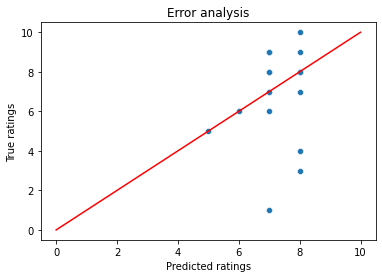

In [ ]:
predictions = [round(recommender(test.index[pos[0]], test.columns[pos[1]], train_similitude, train)) for pos in test_pos.values]
true_values = [test.iloc[pos[0],pos[1]] for pos in test_pos.values]

plt.title('Error analysis')
plt.xlabel('Predicted ratings')
plt.ylabel('True ratings')
sns.lineplot(x=[0,10], y=[0,10], color='red')
sns.scatterplot(x=predictions, y=true_values)
plt.show()

##### Other ways to evaluate our model

In [ ]:
results = pd.DataFrame({
    'predictions':predictions,
    'true_values':true_values
})
results

,predictions,true_values
0,7,7
1,8,7
2,7,8
3,8,8
4,8,9
5,5,5
6,7,8
7,8,10
8,7,6
9,7,9


* Mean Squared Error (MSE): is calculated as the mean or average of the squared differences between predicted and expected target values.
$$MSE = (\frac{1}{n})\sum_{i=1}^{n}(y_{i} - x_{i})^{2}$$

In [ ]:
mse_pre = (results
               .assign(diff = lambda x: (x.true_values - x.predictions)**2)
               .agg({'diff':{'sum','count'}}))
mse = mse_pre.loc['sum'] / mse_pre.loc['count']
mse

diff    5.875
dtype: float64

In [ ]:
# check our results with sklearn metrics
from sklearn.metrics import mean_squared_error
mean_squared_error(results.true_values, results.predictions)

5.875

* Root Mean Squared Error (RMSE): 
$$RMSE = \sqrt{(\frac{1}{n})\sum_{i=1}^{n}(y_{i} - x_{i})^{2}}$$

In [ ]:
rmse = (mse_pre.loc['sum'] / mse_pre.loc['count'])**0.5
rmse

diff    2.42384
dtype: float64

In [ ]:
# check our results with sklearn metrics
mean_squared_error(results.true_values, results.predictions)**0.5

2.4238399287081647

* Mean Absolute Error (MAE)
$$mae = (\frac{1}{n})\sum_{i=1}^{n} |y_{i} - x_{i}|$$

In [ ]:
mae_pre = (results
               .assign(diff = lambda x: abs(x.true_values - x.predictions))
               .agg({'diff':{'sum','count'}}))
mae = mae_pre.loc['sum'] / mae_pre.loc['count']
mae

diff    1.625
dtype: float64

In [ ]:
# check our results with sklearn metrics
from sklearn.metrics import mean_absolute_error
mean_absolute_error(results.true_values, results.predictions)

1.625

To know more about this metrics I recommend to read the following [article](https://machinelearningmastery.com/regression-metrics-for-machine-learning/).

We can create a function to summarise our error metrics:


        MSE: 5.875
        RMSE: 2.4238399287081647
        MEA: 1.625
        


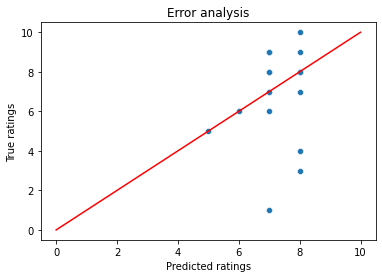

In [ ]:
def predictions_analysis(y_true, preds): 
    print(
        f"""
        MSE: {mean_squared_error(y_true, preds)}
        RMSE: {mean_squared_error(y_true, preds)**0.5}
        MAE: {mean_absolute_error(y_true, preds)}
        """
    )
    plt.title('Error analysis')
    plt.xlabel('Predicted ratings')
    plt.ylabel('True ratings')
    sns.lineplot(x=[0,10], y=[0,10], color='red')
    sns.scatterplot(x=preds, y=y_true)
    plt.show()
    
predictions_analysis(true_values, predictions)

### 7th iteration: calculating distances between users who have given a rating (so excluding the users that has not given a rating (rating = 0))

When we calculate the cosine distances including all the 0 ratings, it will have an impact into our results. We have to find out a way to exclude all the food that has not been rated (value 0) while we are calculating the cosine distance. Let's see how can we do it:

Cosine similarity formula (source: [offical sklearn website](https://scikit-learn.org/stable/modules/metrics.html#metrics)). That is, if $x$ and $y$ are row vectors, their cosine similarity $k$ is defined as:

$$cosine\ similarity = k(x,y) = (\frac{xy}{||x||||y||})$$

In [ ]:
def cosine_similitude_non_zero(data, student, student_to_compare):
    "compute cosine similarity of v1 to v2: (v1 dot v2)/{||v1||*||v2||)"
    cosine_sim_pre = (
    pd.DataFrame({
        'student_1':data.loc[student,:],
        'student_2':data.loc[student_to_compare,:]
    })
        # remove all the foods that has not been rated (rating == 0)
        .query('student_1 != 0 & student_2 != 0')
        # apply cosine formula
        .assign(
            x = lambda x: x.student_1*x.student_1, 
            y = lambda x: x.student_2*x.student_2, 
            xy = lambda x: x.student_1*x.student_2, 
        )
        .agg({'x':'sum', 'y':'sum', 'xy':'sum'})
    )
    cosine_similitude = cosine_sim_pre.loc['xy'] / (cosine_sim_pre.loc['x'] * cosine_sim_pre.loc['y'])**0.5
    return cosine_similitude

cos_sim = [[cosine_similitude_non_zero(train, student, student_to_compare) for student_to_compare in food.index] for student in food.index]
cos_sim_non_zeros = pd.DataFrame(cos_sim, columns=food.index, index=food.index)



        MSE: 6.0
        RMSE: 2.449489742783178
        MEA: 1.75
        


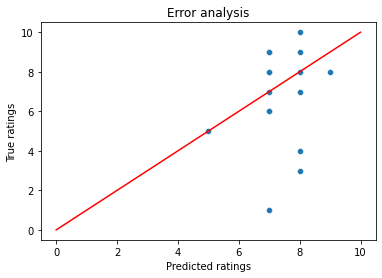

In [ ]:
preds_new_cos = [round(recommender(test.index[pos[0]], test.columns[pos[1]], cos_sim_non_zeros, train)) for pos in test_pos.values]
predictions_analysis(true_values, preds_new_cos)


        MSE: 5.875
        RMSE: 2.4238399287081647
        MEA: 1.625
        


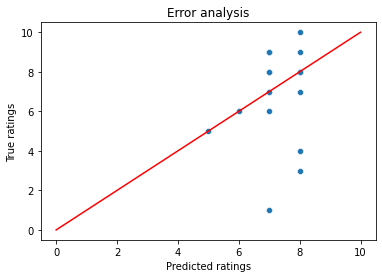

In [ ]:
predictions_analysis(true_values, predictions)

### 8th iteration: transforming our data

When we work with cosine similutude and ratings there is a problem when it comes to compare two cases like:

In [ ]:
temp = pd.DataFrame(
    {
        'student' : ['student_1', 'student_2'] ,
        'broccoli': [1, 10],
        'meat': [1, 10 ]
    }
).set_index('student')
temp

,broccoli,meat
student,,
student_1,1,1
student_2,10,10


Each student rated really different the two foods; student 1 really do not like broccoli and meat, while student 2 really loves it. Let's visualise it to make it more clear: 

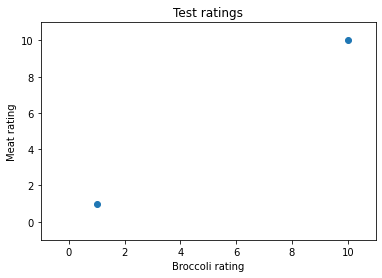

In [ ]:
plt.scatter(temp['broccoli'], temp['meat'])
plt.xlim(-1, 11)
plt.ylim(-1, 11)
plt.title('Test ratings')
plt.xlabel('Broccoli rating')
plt.ylabel('Meat rating')
plt.show()

If we look at the angle between the two different points would be 0. So the cosine similitude will be 1. This will mean that our model will be considering this two users really close to each other, when they are really different!

In [ ]:
cosine_similitude_non_zero(temp, 'student_1','student_2')

1.0

So we have to figure out which transformation we should to our dataset to avoid this problem.

In [ ]:
temp_transformed = temp - 4.9
temp_transformed

,broccoli,meat
student,,
student_1,-3.9,-3.9
student_2,5.1,5.1


I decided to transform into negative values all the values below to 5. I choosed the value 4.9 as it will avoid that any value will become exactly 0, and then it will not be excluded from our function `cosine_similitude_non_zero` which considers the 0 as non rated foods.

Let's visualise the tranformed ratingsz:

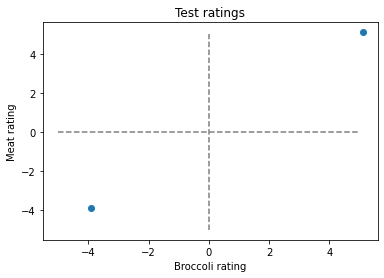

In [ ]:
plt.scatter(temp_transformed['broccoli'], temp_transformed['meat'])
plt.hlines(0, -5, 5, color='gray', linestyle='--')
plt.vlines(0, -5, 5, color='gray', linestyle='--')
plt.title('Test ratings')
plt.xlabel('Broccoli rating')
plt.ylabel('Meat rating')
plt.show()

And now if we calculate the cosine similitude between each value: 

In [ ]:
cosine_similitude_non_zero(temp_transformed, 'student_1','student_2')

-1.0

Let's apply it into my foods dataset:


        MSE: 8.5
        RMSE: 2.9154759474226504
        MEA: 2.0
        


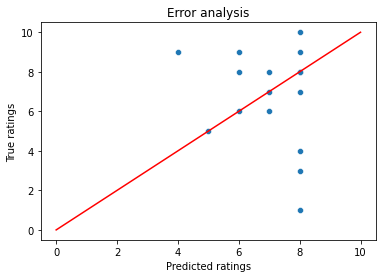

In [ ]:
# replace 0 values to nan. This step is done to avoid applying the tranformation also to non rated foods
train_transformed = train.replace({0: np.nan}).copy()
# apply transformation to transform low ratings into negative values
train_transformed = train_transformed - 4.9
# turn back missing values to 0
train_transformed = train_transformed.replace({np.nan: 0})
# calculate the cosine similitude matrix
cos_dist = [[cosine_similitude_non_zero(train_transformed, student, student_to_compare) for student_to_compare in food.index] for student in food.index]
cos_dist_non_zeros = pd.DataFrame(cos_dist, columns=food.index, index=food.index)
# get the recommendations for the test set
preds_new_cos = [round(recommender(test.index[pos[0]], test.columns[pos[1]], cos_dist_non_zeros, train_transformed) + 4.5) for pos in test_pos.values]
# analyse its results
predictions_analysis(true_values, preds_new_cos)